### Modelling

There are two obstackles with the data we have prepared for modelling. One is the size of the dataset. $1.8$M datapoints are too many to be processed in a personal machine. This issue can be adddressed by subsampling. The other issue we have is that our data is imbalanced. There are many methods we can try to address this. One could be just downsampling. This was done and the results were not as expected. The other approach is using SMOTE. This gave us the best results, with an accuracy higher than $40\%$. As for the models, we will try DecisionTree,  Random Forest and  KNN (if the machine allows us to do so). After we have run each model we will get the corresponding confusion matrix, recall and precision.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [2]:
%%time
X = pd.read_csv('C:\\Users\\francisco\\Desktop\\BrainStation\\Capstoneproject_BS\\FiresUSA\\fires_X.csv')

Wall time: 45.6 s


In [3]:
%%time
y = pd.read_csv('C:\\Users\\francisco\\Desktop\\BrainStation\\Capstoneproject_BS\\FiresUSA\\fires_y.csv')

Wall time: 2.5 s


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1789378 entries, 0 to 1789377
Columns: 120 entries, FIRE_SIZE to STATE_WY
dtypes: float64(3), int64(117)
memory usage: 1.6 GB


In [5]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1789378 entries, 0 to 1789377
Data columns (total 1 columns):
 #   Column                Dtype
---  ------                -----
 0   STAT_CAUSE_DESCR_cat  int64
dtypes: int64(1)
memory usage: 13.7 MB


Our next steps include:

* Downsampling and upsampling our data.
* Scaling our data so that we can use it with various models (this is not necessary to run a Decision Tree or a Random Fores but it is important for KNN)
* If possible, reduce the number of features using PCA. This will address the problem of multicoliarity and it particularly important for KNN.
* Model to run: Decision Tree, RandomForest and KNN.

In [6]:
# Below we import some of the libraries and packages we may need
#from sklearn.feature_extraction.text import CountVectorizer
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score
%matplotlib inline

This dataset is too large to be processed as our models are computational expensive. Therefore, we will work with a subsample of the data.

In [7]:
%time
X_subsample, X_rest, y_subsample, y_rest = \
        train_test_split(X, y, test_size = 0.995, random_state=2020)

Wall time: 0 ns


Let us scale our data and then we split it to get the test set.

In [8]:
%%time

# Splitting the data into the test and remainder data:
X_remainder, X_test, y_remainder, y_test = \
        train_test_split(X_subsample, y_subsample, test_size = 0.3, random_state=2020)


# Scaling:
scaler = StandardScaler()
scaler.fit(X_remainder)
X_remainder = scaler.transform(X_remainder)
X_test = scaler.transform(X_test)

Wall time: 42.7 s
Parser   : 114 ms


In [9]:
X_remainder.shape

(6262, 120)

In [10]:
y_remainder.shape

(6262, 1)

We will address the imbalance problem in our data using SMOTE. We will do an oversample and an undersampling using `X_remainder` and `y_remainder`.

In [11]:
import imblearn
print(imblearn.__version__)

0.7.0


In [12]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [13]:
%%time
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_remainder, y_remainder)
print(sorted(Counter(y_resampled).items()))

[('STAT_CAUSE_DESCR_cat', 1)]
Wall time: 1min 7s


In [14]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_remainder, y_remainder)
print(sorted(Counter(y_resampled).items()))

[('STAT_CAUSE_DESCR_cat', 1)]


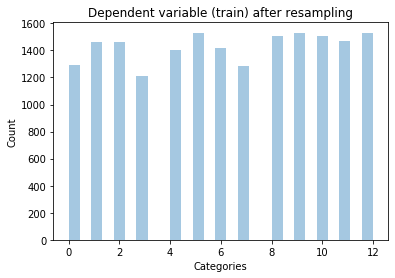

In [15]:
plt.figure()
sns.distplot(y_resampled, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Dependent variable (train) after resampling')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

Below we store the data we havee processed so far to have it at hand.

In [16]:
%%time
# From numpy array to pandas daaframe
X0 = pd.DataFrame(data = X_resampled, index=None, columns=None)
#from pandas df to csv
X0.to_csv(r'C:\Users\francisco\Desktop\BrainStation\Capstoneproject_BS\FiresUSA\fires_X_smote.csv', index = False)

##
y0 = pd.DataFrame(data = y_resampled, index=None, columns=None)

##

y0.to_csv(r'C:\Users\francisco\Desktop\BrainStation\Capstoneproject_BS\FiresUSA\fires_y_smote.csv', index = False)




X00 = pd.DataFrame(data = X_test, index=None, columns=None)
#from pandas df to csv
X00.to_csv(r'C:\Users\francisco\Desktop\BrainStation\Capstoneproject_BS\FiresUSA\fires_X_smote_test.csv', index = False)


y00 = pd.DataFrame(data = y_test, index=None, columns=None)
#from pandas df to csv
y00.to_csv(r'C:\Users\francisco\Desktop\BrainStation\Capstoneproject_BS\FiresUSA\fires_y_smote_test.csv', index = False)


Wall time: 33.8 s


### The cell below is made to be able to run  the random forest

In [17]:
X_rf, X_resto, y_rf, y_resto = \
        train_test_split(X_resampled, y_resampled, test_size = 0.9, random_state=2020)


X_rf_test, X_restos, y_rf_test, y_restos = \
        train_test_split(X_test, y_test, test_size = 0.9, random_state=2020)

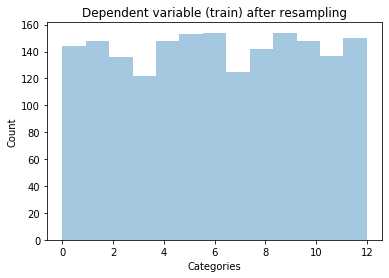

In [18]:
plt.figure()
sns.distplot(y_rf, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Dependent variable (train) after resampling')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

### Random Forest

#### Random Forest without PCA

In [113]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', RandomForestClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[None],
'model': [RandomForestClassifier(n_estimators=100)],
'model__max_features': [3, 4, 5, 6]}
#np.arange(1, 20)
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.9s finished
C:\Users\francisco\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Wall time: 8.88 s


In [21]:
# What is the best pipeline?
fittedgrid.best_estimator_

Pipeline(steps=[('dimensionality', None),
                ('model', RandomForestClassifier(max_features=6))])

In [115]:
# Score
fittedgrid.score(X_test, y_test)

0.36475409836065575

In [116]:
# Accuracy
fittedgrid.score(X_rf, y_rf)

1.0

We can store the accuracies and scores in a dictionary.

In [76]:
acc_dic = {}
acc_dic['RF_without_PCA'] = ('Acc: 0.37', 'Score: 1.0' )

In [24]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)
y_pred

array([0, 6, 4, ..., 8, 0, 8], dtype=int64)

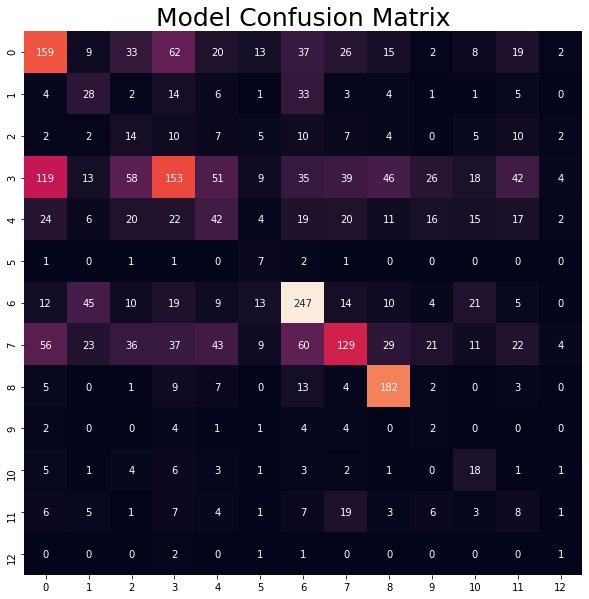

Wall time: 2.74 s


In [25]:
%%time
from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [26]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.39259259 0.2745098  0.17948718 0.24959217 0.19266055 0.53846154
 0.60391198 0.26875    0.80530973 0.11111111 0.39130435 0.11267606
 0.2       ]

Precision: [0.40253165 0.21212121 0.07777778 0.44219653 0.21761658 0.10769231
 0.52441614 0.48134328 0.59672131 0.025      0.18       0.06060606
 0.05882353]

Recall mean: 0.3323359280621243

Precision mean: 0.26052664432462574


Below we will determine wich features have the most predictive power.

In [27]:
#fittedgrid.best_estimator_.feature_importances_()

fittedgrid.best_estimator_[1].feature_importances_

array([6.74728950e-02, 8.84662535e-02, 9.00898684e-02, 8.27517088e-02,
       8.31237382e-02, 7.02452476e-02, 1.61101951e-02, 2.96525416e-03,
       1.29610392e-02, 1.30439252e-02, 3.83675904e-04, 1.11664137e-02,
       8.20056470e-04, 9.28014805e-04, 1.54892476e-04, 1.60827041e-03,
       4.82906204e-03, 5.61043460e-04, 7.78012125e-04, 3.47389485e-03,
       2.94244437e-04, 4.39925304e-04, 1.14671823e-02, 2.80642544e-03,
       7.65207795e-04, 1.97361970e-03, 1.32105289e-03, 1.20135368e-03,
       3.74607991e-04, 3.94469957e-03, 4.17915282e-04, 2.02142118e-02,
       2.86981298e-03, 0.00000000e+00, 1.27627946e-04, 2.30915269e-03,
       1.00466393e-03, 1.86316005e-03, 3.85199888e-04, 1.10296209e-03,
       8.47482799e-03, 1.67322154e-03, 1.14550527e-03, 7.88483818e-04,
       1.90718011e-03, 0.00000000e+00, 2.76084826e-02, 2.82196737e-02,
       1.38833455e-02, 1.55966775e-03, 1.89175071e-03, 1.03293562e-03,
       0.00000000e+00, 2.11344894e-02, 6.81409121e-03, 0.00000000e+00,
      

#### Random Forest with PCA

In [28]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', RandomForestClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[PCA()],
'model': [RandomForestClassifier(n_estimators=100)],
'dimensionality__n_components':np.arange(1,min(X_rf.shape)),
'model__max_features': [3, 4, 5, 6]}
#np.arange(1, 20)
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 476 candidates, totalling 2380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 2380 out of 2380 | elapsed: 15.3min finished
C:\Users\francisco\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Wall time: 15min 21s


In [30]:
# What is the best pipeline?
print('Best estimator:', fittedgrid.best_estimator_)

# Accuracy
print('Accuracy:', fittedgrid.score(X_test, y_test))

print('')

# Score
print('Score:', fittedgrid.score(X_rf, y_rf))

Accuracy: 0.3450074515648286

Score: 1.0


In [77]:
acc_dic['RF_with_PCA'] = ('Acc: 0.34', 'Score: 1.0' )

Let us see the confusion matrix.

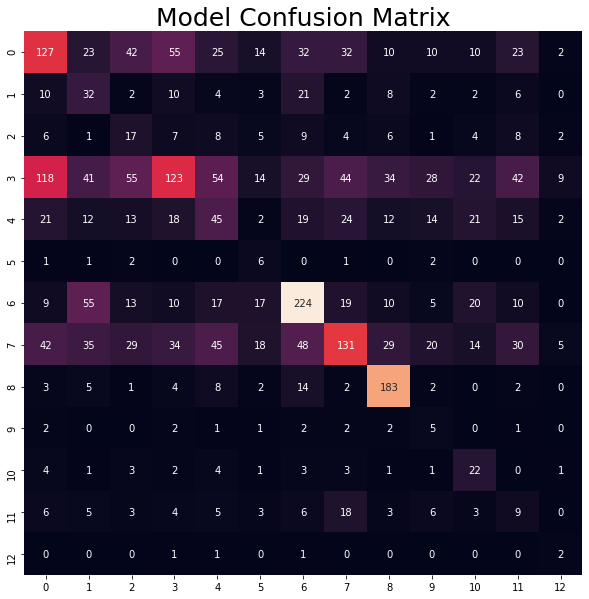

In [32]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

From the confusion matrix we can see recall and precision of this model 

In [33]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.31358025 0.31372549 0.21794872 0.20065253 0.20642202 0.46153846
 0.54767726 0.27291667 0.80973451 0.27777778 0.47826087 0.12676056
 0.4       ]

Precision: [0.36389685 0.15165877 0.09444444 0.45555556 0.20737327 0.06976744
 0.54901961 0.46453901 0.61409396 0.05208333 0.18644068 0.06164384
 0.08695652]

Recall mean: 0.3559227012131968

Precision mean: 0.25826717484475364


Below we can see which features are most important

In [34]:
#fittedgrid.best_estimator_.feature_importances_()

fittedgrid.best_estimator_[1].feature_importances_

array([0.01775187, 0.01735712, 0.01942793, 0.01534728, 0.01600619,
       0.01639769, 0.01065644, 0.01281556, 0.01537267, 0.01030639,
       0.01199498, 0.0103676 , 0.01081507, 0.01073294, 0.01121749,
       0.01049562, 0.00983267, 0.01131093, 0.00943787, 0.00968967,
       0.01082891, 0.01248207, 0.01259221, 0.01113097, 0.00906093,
       0.00953555, 0.00772   , 0.00988882, 0.00874323, 0.00865374,
       0.01110664, 0.00887905, 0.00973825, 0.00806889, 0.00941556,
       0.00889305, 0.00964664, 0.00972797, 0.00797102, 0.01019868,
       0.00956169, 0.01168258, 0.00866992, 0.00917303, 0.00761429,
       0.00893146, 0.00966015, 0.01128153, 0.00921788, 0.00906854,
       0.00795078, 0.00974518, 0.00908758, 0.00789678, 0.00884595,
       0.0078868 , 0.00992593, 0.00875509, 0.0083706 , 0.0081086 ,
       0.0079032 , 0.01016289, 0.00858256, 0.0091539 , 0.00935511,
       0.00872063, 0.00806495, 0.00942433, 0.00877439, 0.01200226,
       0.00949949, 0.00917176, 0.00854079, 0.01049344, 0.00912

### Decision Tree

#### Without PCA

In [53]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[None],
 'model': [DecisionTreeClassifier()],
 'model__max_depth':np.arange(1, 25)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 1.93 s


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.8s finished


In [54]:
# What is the best pipeline?
print(fittedgrid.best_estimator_)

# Accuracy
print('Accuracy:', fittedgrid.score(X_test, y_test))

print('')

# Score
print('Score:', fittedgrid.score(X_rf, y_rf))

Pipeline(steps=[('dimensionality', None),
                ('model', DecisionTreeClassifier(max_depth=24))])
Accuracy: 0.30700447093889716

Score: 0.907576571735626


In [78]:
acc_dic['DT_without_PCA'] = ('Acc: 0.30', 'Score: 0.9' )


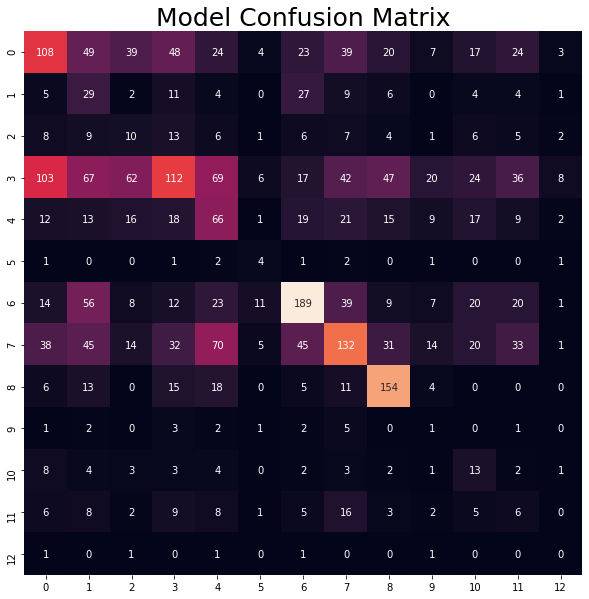

In [55]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [56]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

#fittedgrid.best_estimator_.feature_importances_()

Recall: [0.26666667 0.28431373 0.12820513 0.18270799 0.30275229 0.30769231
 0.46210269 0.275      0.68141593 0.05555556 0.2826087  0.08450704
 0.        ]

Precision: [0.34726688 0.09830508 0.06369427 0.40433213 0.22222222 0.11764706
 0.55263158 0.40490798 0.52920962 0.01470588 0.1031746  0.04285714
 0.        ]

Recall mean: 0.25488677132756443

Precision mean: 0.2231503422373524


In [57]:
fittedgrid.best_estimator_[1].feature_importances_

array([0.07759886, 0.06225147, 0.09374553, 0.10626306, 0.12821692,
       0.07774954, 0.02642729, 0.        , 0.        , 0.00489524,
       0.        , 0.00583105, 0.00066356, 0.        , 0.        ,
       0.        , 0.00191828, 0.0015483 , 0.        , 0.        ,
       0.        , 0.        , 0.0389265 , 0.0011944 , 0.00148194,
       0.00270006, 0.        , 0.        , 0.        , 0.00818412,
       0.        , 0.0148247 , 0.00582388, 0.        , 0.        ,
       0.00666471, 0.        , 0.00097954, 0.        , 0.        ,
       0.02128351, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0166458 , 0.01516961, 0.01100875, 0.        ,
       0.00152618, 0.        , 0.        , 0.05740583, 0.00136503,
       0.        , 0.        , 0.        , 0.        , 0.00649465,
       0.        , 0.        , 0.        , 0.03374609, 0.        ,
       0.00221185, 0.        , 0.00793957, 0.        , 0.02000491,
       0.        , 0.00868368, 0.00066356, 0.00210796, 0.     

#### With PCA

In [58]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[PCA()],
 'model': [DecisionTreeClassifier()],
 'dimensionality__n_components':np.arange(1,min(X_rf.shape)),
 'model__max_depth':np.arange(1, 25)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 2856 candidates, totalling 14280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6468 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 7118 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 7868 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 8718 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 9668 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 10718 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 11868 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 13118 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 14280 out of 14280 | elapsed: 15.0min finished


Wall time: 15min


In [60]:
# What is the best pipeline?
fittedgrid.best_estimator_

# Accuracy
print('Accuracy:', fittedgrid.score(X_test, y_test))

print('')

# Score
print('Score:', fittedgrid.score(X_rf, y_rf))

Accuracy: 0.26527570789865873

Score: 0.9618484685652875


In [81]:
acc_dic['DT_with_PCA'] = ('Acc: 0.26', 'Score: 0.96' )

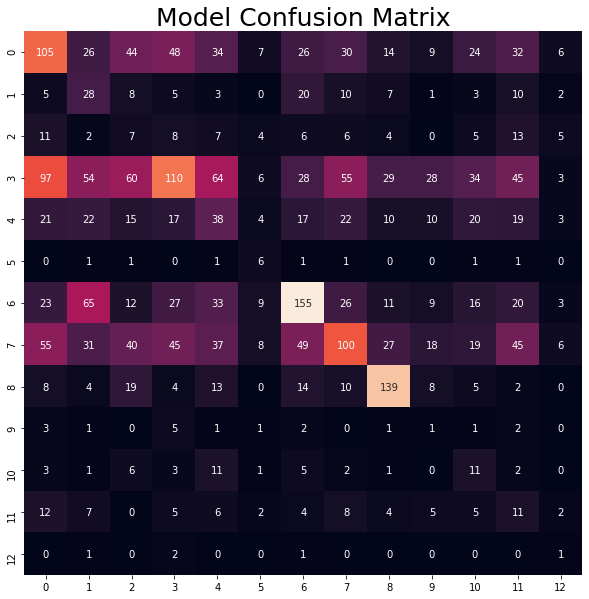

In [61]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [62]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.25925926 0.2745098  0.08974359 0.17944535 0.17431193 0.46153846
 0.37897311 0.20833333 0.61504425 0.05555556 0.23913043 0.15492958
 0.2       ]

Precision: [0.30612245 0.11522634 0.03301887 0.39426523 0.15322581 0.125
 0.47256098 0.37037037 0.56275304 0.01123596 0.07638889 0.05445545
 0.03225806]

Recall mean: 0.25313651122006536

Precision mean: 0.2082216484771022


In [63]:
#fittedgrid.best_estimator_.feature_importances_()

fittedgrid.best_estimator_[1].feature_importances_

array([0.06475172, 0.04624311, 0.05905456, 0.0418364 , 0.01526512,
       0.04992802, 0.01568742, 0.00834676, 0.0185412 , 0.01271755,
       0.        , 0.01476121, 0.01309038, 0.01163173, 0.01087092,
       0.00910399, 0.00579995, 0.02378513, 0.01281071, 0.0083823 ,
       0.01387609, 0.03470342, 0.01749158, 0.01204661, 0.02316125,
       0.00869278, 0.01414471, 0.00419391, 0.00861182, 0.01131148,
       0.00928329, 0.01447317, 0.0142157 , 0.00682652, 0.02320218,
       0.0035665 , 0.01368025, 0.01512761, 0.01458272, 0.00762954,
       0.01807835, 0.00397524, 0.01443542, 0.00879501, 0.01294388,
       0.01052828, 0.00694934, 0.00562506, 0.0105968 , 0.01673006,
       0.01276384, 0.01770053, 0.0125962 , 0.01575357, 0.00998746,
       0.00925741, 0.01249484, 0.01830538, 0.01313627, 0.00587194,
       0.01582805, 0.0171427 , 0.01707509])

In terms of accuracy, the DecisionTree performs better without PCA.

### KNN 

Int the case of KNN, it is important to combine the model with PCA

In [69]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names



estimators = [('dimensionality', PCA()),
              ('model', KNeighborsClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{ 'dimensionality':[PCA()],
 'model': [KNeighborsClassifier()],
  'dimensionality__n_components':np.arange(1,min(X_rf.shape)),
  'model__n_neighbors':np.arange(1, 7)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 714 candidates, totalling 3570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1492 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 2392 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3492 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3563 out of 3570 | elapsed:  3.4min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 3570 out of 3570 | elapsed:  3.4min finished


Wall time: 3min 26s


C:\Users\francisco\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [73]:
# What is the best pipeline?
print(fittedgrid.best_estimator_)

# Accuracy
print('Accuracy:', fittedgrid.score(X_test, y_test))

print('')

# Score
print('Score:', fittedgrid.score(X_rf, y_rf))

Pipeline(steps=[('dimensionality', PCA(n_components=100)),
                ('model', KNeighborsClassifier(n_neighbors=1))])
Accuracy: 0.3289865871833085

Score: 1.0


In [80]:
acc_dic['KNN_with_PCA'] = ('Acc: 0.32', 'Score: 1.0' )

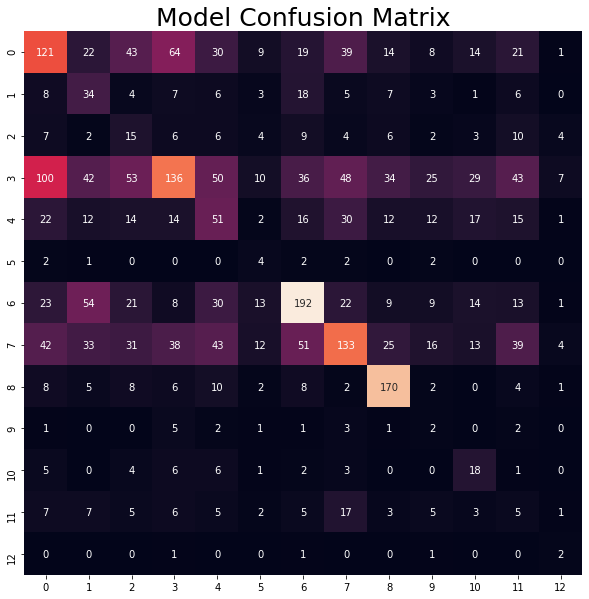

In [74]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [75]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.29876543 0.33333333 0.19230769 0.22185971 0.23394495 0.30769231
 0.46943765 0.27708333 0.75221239 0.11111111 0.39130435 0.07042254
 0.4       ]

Precision: [0.34971098 0.16037736 0.07575758 0.45791246 0.21338912 0.06349206
 0.53333333 0.43181818 0.60498221 0.02298851 0.16071429 0.03144654
 0.09090909]

Recall mean: 0.3122672919689814

Precision mean: 0.24591013111221158


Let us compare the different accuracies and scores we have obtained so far

In [82]:
acc_dic

{'RF_without_PCA': ('Acc: 0.37', 'Score: 1.0'),
 'RF_with_PCA': ('Acc: 0.34', 'Score: 1.0'),
 'DT_without_PCA': ('Acc: 0.30', 'Score: 0.9'),
 'DT_with_PCA': ('Acc: 0.26', 'Score: 0.96'),
 'KNN_with_PCA': ('Acc: 0.32', 'Score: 1.0')}

In terms of accuracy, Random Forest without PCA is the best. 

### Random Forest with imbalanced data.

In [98]:
X_imb, X_resto, y_imb, y_resto = \
        train_test_split(X_remainder, y_remainder, test_size = 0.7, random_state=2020)


X_imb_test, X_restos, y_imb_test, y_restos = \
        train_test_split(X_test, y_test, test_size = 0.7, random_state=2020)

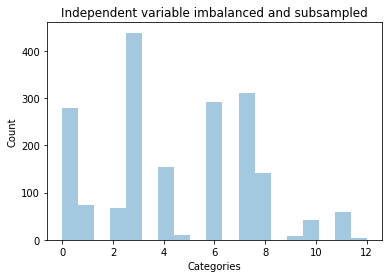

In [112]:
plt.figure()
sns.distplot(y_imb, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Independent variable imbalanced and subsampled')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [100]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', RandomForestClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[PCA()],
'model': [RandomForestClassifier(n_estimators=100)],
'dimensionality__n_components':np.arange(1,min(X_imb.shape)),
'model__max_features': [3, 4, 5, 6]}
#np.arange(1, 20)
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_imb, y_imb)

Fitting 5 folds for each of 476 candidates, totalling 2380 fits


C:\Users\francisco\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2380 out of 2380 | elapsed: 15.0min finished
C:\Users\francisco\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimato

Wall time: 14min 59s


In [103]:
# What is the best pipeline?
print('Best estimator:', fittedgrid.best_estimator_)

# Accuracy
print('Accuracy:', fittedgrid.score(X_imb_test, y_imb_test))

print('')

# Score
print('Score:', fittedgrid.score(X_imb, y_imb))

Best estimator: Pipeline(steps=[('dimensionality', PCA(n_components=20)),
                ('model', RandomForestClassifier(max_features=6))])
Accuracy: 0.42857142857142855

Score: 0.8221512247071352


In [107]:
acc_dic['RF_with_Imbalanced_data'] = ('Acc:0.42', 'Score:0.82')

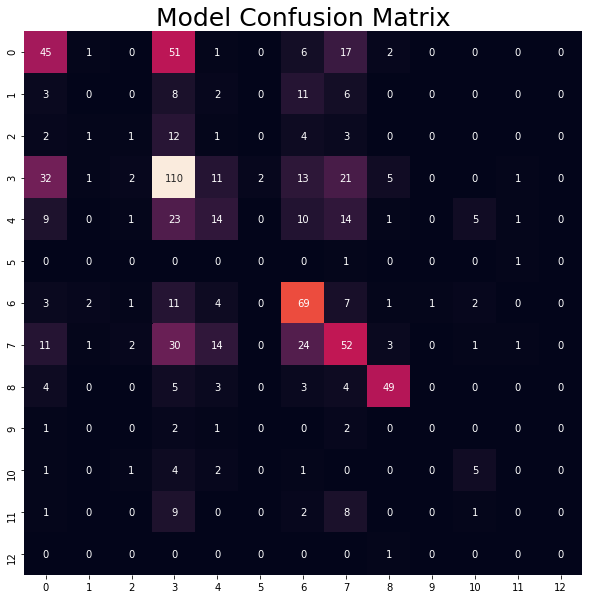

In [109]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_imb_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_imb_test)

y_pred = fittedgrid.predict(X_imb_test)

conf_mat = confusion_matrix(y_imb_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [110]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.36585366 0.         0.04166667 0.55555556 0.17948718 0.
 0.68316832 0.37410072 0.72058824 0.         0.35714286 0.
 0.        ]

Precision: [0.40178571 0.         0.125      0.41509434 0.26415094 0.
 0.48251748 0.38518519 0.79032258 0.         0.35714286 0.
        nan]

Recall mean: 0.25212024530300814

Precision mean: nan


C:\Users\francisco\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [111]:
#fittedgrid.best_estimator_.feature_importances_()

fittedgrid.best_estimator_[1].feature_importances_

array([0.08685473, 0.05769692, 0.04732754, 0.05652899, 0.05646508,
       0.05230623, 0.04935812, 0.05730311, 0.05558653, 0.04375128,
       0.04286354, 0.04452939, 0.04420014, 0.04072347, 0.0464096 ,
       0.0420057 , 0.044541  , 0.04368748, 0.04726072, 0.04060045])

### Other resampling methods

(6262, 120)

Below we do the oversampling. 

In [117]:
# transform the dataset
oversample = SMOTE()
#Fit the data
X_over, y_over = oversample.fit_resample(X_remainder, y_remainder)

In [118]:
%%time
# transform the dataset
oversample = RandomUnderSampler()
#Fit the data
X_under, y_under = oversample.fit_resample(X_remainder, y_remainder)

Wall time: 8.01 ms


Let us check that everythig looks as excepted.

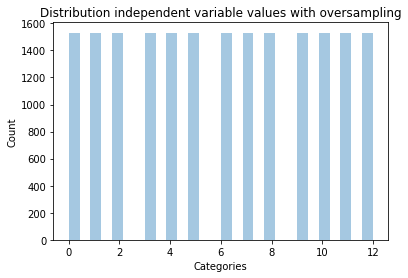

In [123]:
plt.figure()
sns.distplot(y_over, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Distribution independent variable values with oversampling')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

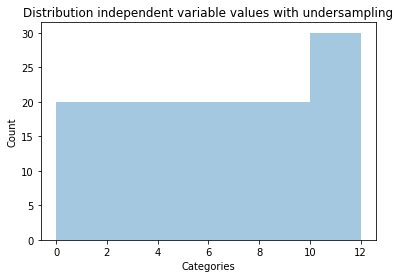

In [120]:
plt.figure()
sns.distplot(y_under, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Distribution independent variable values with undersampling')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

We will use ``X_over`` and ``y_over`` to train the models below

In [148]:
X_rf = X_over

y_rf = y_over

In [149]:
X_rf.shape

(19903, 120)

We will store ``X_over`` and ``y_over``

In [150]:
%%time
# From numpy array to pandas daaframe
X0 = pd.DataFrame(data = X_over, index=None, columns=None)
#from pandas df to csv
X0.to_csv(r'C:\Users\francisco\Desktop\BrainStation\Capstoneproject_BS\FiresUSA\fires_X_over.csv', index = False)

##
y0 = pd.DataFrame(data = y_resampled, index=None, columns=None)

##

y0.to_csv(r'C:\Users\francisco\Desktop\BrainStation\Capstoneproject_BS\FiresUSA\fires_y_over.csv', index = False)




X00 = pd.DataFrame(data = X_test, index=None, columns=None)
#from pandas df to csv
X00.to_csv(r'C:\Users\francisco\Desktop\BrainStation\Capstoneproject_BS\FiresUSA\fires_X_over_test.csv', index = False)


y00 = pd.DataFrame(data = y_test, index=None, columns=None)
#from pandas df to csv
y00.to_csv(r'C:\Users\francisco\Desktop\BrainStation\Capstoneproject_BS\FiresUSA\fires_y_over_test.csv', index = False)


Wall time: 7.53 s


### Random Forest

#### Random Forest without PCA

In [129]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', RandomForestClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[None],
'model': [RandomForestClassifier(n_estimators=100)],
'model__max_features': [2, 3, 4, 5, 6]}
#np.arange(1, 20)
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   40.1s finished
C:\Users\francisco\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Wall time: 44.6 s


In [130]:
# What is the best pipeline?
fittedgrid.best_estimator_

Pipeline(steps=[('dimensionality', None),
                ('model', RandomForestClassifier(max_features=4))])

In [131]:
# Score
fittedgrid.score(X_test, y_test)

0.44076005961251863

In [132]:
# Accuracy
fittedgrid.score(X_rf, y_rf)

1.0

We can store the accuracies and scores in a dictionary.

In [141]:
acc_dic_over = {}
acc_dic['RF_without_PCA'] = ('Acc: 0.44', 'Score: 1.0' )

In [134]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)
y_pred

array([0, 6, 4, ..., 8, 7, 8], dtype=int64)

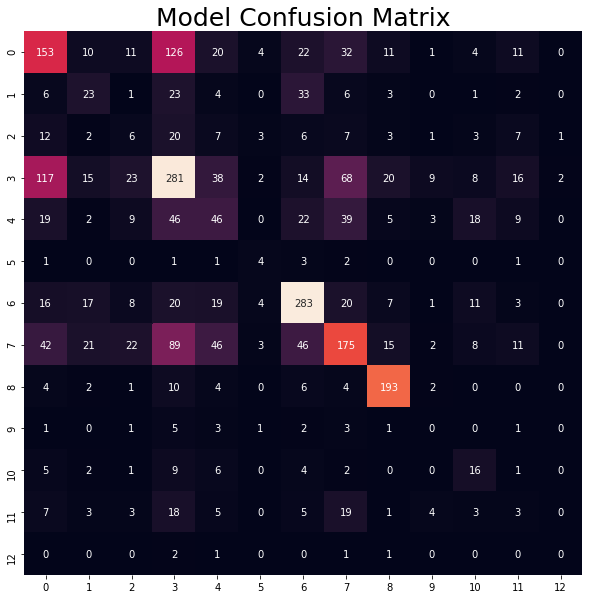

Wall time: 1.51 s


In [135]:
%%time
from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [136]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.37777778 0.2254902  0.07692308 0.45840131 0.21100917 0.30769231
 0.69193154 0.36458333 0.8539823  0.         0.34782609 0.04225352
 0.        ]

Precision: [0.39947781 0.2371134  0.06976744 0.43230769 0.23       0.19047619
 0.63452915 0.46296296 0.74230769 0.         0.22222222 0.04615385
 0.        ]

Recall mean: 0.30445158619111434

Precision mean: 0.2821014157787309


Below we will determine wich features have the most predictive power.

In [142]:
#fittedgrid.best_estimator_.feature_importances_()

fittedgrid.best_estimator_[1].feature_importances_

array([7.11822169e-02, 9.80243483e-02, 1.00036280e-01, 9.07676114e-02,
       9.04780961e-02, 8.09682894e-02, 1.03817717e-02, 2.83173337e-03,
       1.17752586e-02, 1.29443242e-02, 3.74512305e-04, 1.04702236e-02,
       7.83851627e-04, 1.47775053e-03, 1.56085635e-04, 2.21682300e-03,
       4.41429438e-03, 6.19801663e-04, 4.73414701e-04, 3.33871578e-03,
       1.50175468e-04, 5.83381166e-04, 9.44947699e-03, 1.90582115e-03,
       6.00718398e-04, 1.35454546e-03, 1.26939168e-03, 4.40711247e-04,
       6.01098548e-04, 3.18398539e-03, 6.71681257e-04, 1.69203440e-02,
       2.17508444e-03, 0.00000000e+00, 7.77585149e-04, 2.37380086e-03,
       9.29275976e-04, 3.13230025e-03, 2.66999548e-04, 8.40253636e-04,
       6.16213903e-03, 1.46587341e-03, 1.11590801e-03, 6.29520840e-04,
       2.11015795e-03, 9.92210570e-05, 2.42237213e-02, 2.49229635e-02,
       1.15666073e-02, 1.88984810e-03, 2.49128671e-03, 1.02442258e-03,
       1.84008681e-04, 1.89205649e-02, 5.80060914e-03, 0.00000000e+00,
      

#### Random Forest with PCA

In [143]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', RandomForestClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[PCA()],
'model': [RandomForestClassifier(n_estimators=100)],
'dimensionality__n_components':np.arange(1,min(X_rf.shape)),
'model__max_features': [3, 4, 5, 6]}
#np.arange(1, 20)
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 476 candidates, totalling 2380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  9.1min


KeyboardInterrupt: 

In [144]:
# What is the best pipeline?
print('Best estimator:', fittedgrid.best_estimator_)

# Accuracy
print('Accuracy:', fittedgrid.score(X_test, y_test))

print('')

# Score
print('Score:', fittedgrid.score(X_rf, y_rf))

Best estimator: Pipeline(steps=[('dimensionality', None),
                ('model', RandomForestClassifier(max_features=4))])
Accuracy: 0.44076005961251863

Score: 1.0


In [77]:
acc_dic_over['RF_with_PCA'] = ('Acc: 0.34', 'Score: 1.0' )

Let us see the confusion matrix.

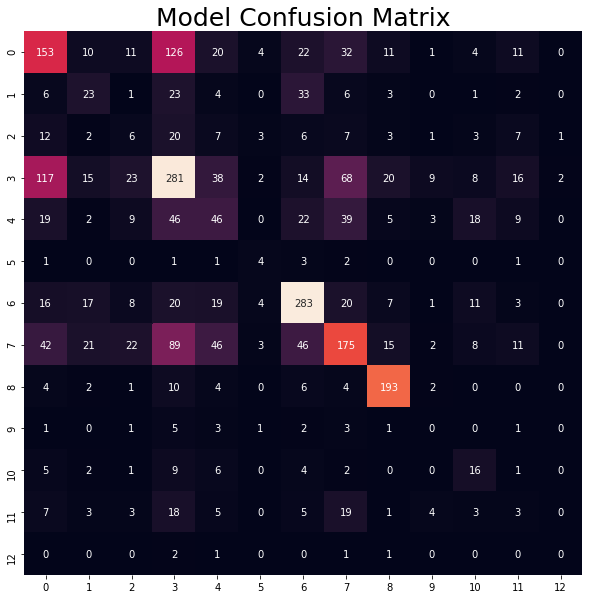

In [145]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

From the confusion matrix we can see recall and precision of this model 

In [146]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.37777778 0.2254902  0.07692308 0.45840131 0.21100917 0.30769231
 0.69193154 0.36458333 0.8539823  0.         0.34782609 0.04225352
 0.        ]

Precision: [0.39947781 0.2371134  0.06976744 0.43230769 0.23       0.19047619
 0.63452915 0.46296296 0.74230769 0.         0.22222222 0.04615385
 0.        ]

Recall mean: 0.30445158619111434

Precision mean: 0.2821014157787309


Below we can see which features are most important

In [147]:
#fittedgrid.best_estimator_.feature_importances_()

fittedgrid.best_estimator_[1].feature_importances_

array([7.11822169e-02, 9.80243483e-02, 1.00036280e-01, 9.07676114e-02,
       9.04780961e-02, 8.09682894e-02, 1.03817717e-02, 2.83173337e-03,
       1.17752586e-02, 1.29443242e-02, 3.74512305e-04, 1.04702236e-02,
       7.83851627e-04, 1.47775053e-03, 1.56085635e-04, 2.21682300e-03,
       4.41429438e-03, 6.19801663e-04, 4.73414701e-04, 3.33871578e-03,
       1.50175468e-04, 5.83381166e-04, 9.44947699e-03, 1.90582115e-03,
       6.00718398e-04, 1.35454546e-03, 1.26939168e-03, 4.40711247e-04,
       6.01098548e-04, 3.18398539e-03, 6.71681257e-04, 1.69203440e-02,
       2.17508444e-03, 0.00000000e+00, 7.77585149e-04, 2.37380086e-03,
       9.29275976e-04, 3.13230025e-03, 2.66999548e-04, 8.40253636e-04,
       6.16213903e-03, 1.46587341e-03, 1.11590801e-03, 6.29520840e-04,
       2.11015795e-03, 9.92210570e-05, 2.42237213e-02, 2.49229635e-02,
       1.15666073e-02, 1.88984810e-03, 2.49128671e-03, 1.02442258e-03,
       1.84008681e-04, 1.89205649e-02, 5.80060914e-03, 0.00000000e+00,
      

### Decision Tree

#### Without PCA

In [53]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[None],
 'model': [DecisionTreeClassifier()],
 'model__max_depth':np.arange(1, 25)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 1.93 s


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.8s finished


In [54]:
# What is the best pipeline?
print(fittedgrid.best_estimator_)

# Accuracy
print('Accuracy:', fittedgrid.score(X_test, y_test))

print('')

# Score
print('Score:', fittedgrid.score(X_rf, y_rf))

Pipeline(steps=[('dimensionality', None),
                ('model', DecisionTreeClassifier(max_depth=24))])
Accuracy: 0.30700447093889716

Score: 0.907576571735626


In [78]:
acc_dic['DT_without_PCA'] = ('Acc: 0.30', 'Score: 0.9' )


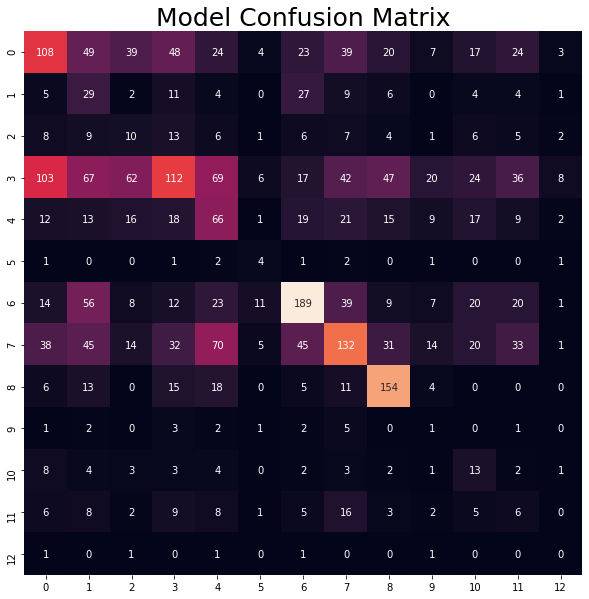

In [55]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [56]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

#fittedgrid.best_estimator_.feature_importances_()

Recall: [0.26666667 0.28431373 0.12820513 0.18270799 0.30275229 0.30769231
 0.46210269 0.275      0.68141593 0.05555556 0.2826087  0.08450704
 0.        ]

Precision: [0.34726688 0.09830508 0.06369427 0.40433213 0.22222222 0.11764706
 0.55263158 0.40490798 0.52920962 0.01470588 0.1031746  0.04285714
 0.        ]

Recall mean: 0.25488677132756443

Precision mean: 0.2231503422373524


In [57]:
fittedgrid.best_estimator_[1].feature_importances_

array([0.07759886, 0.06225147, 0.09374553, 0.10626306, 0.12821692,
       0.07774954, 0.02642729, 0.        , 0.        , 0.00489524,
       0.        , 0.00583105, 0.00066356, 0.        , 0.        ,
       0.        , 0.00191828, 0.0015483 , 0.        , 0.        ,
       0.        , 0.        , 0.0389265 , 0.0011944 , 0.00148194,
       0.00270006, 0.        , 0.        , 0.        , 0.00818412,
       0.        , 0.0148247 , 0.00582388, 0.        , 0.        ,
       0.00666471, 0.        , 0.00097954, 0.        , 0.        ,
       0.02128351, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0166458 , 0.01516961, 0.01100875, 0.        ,
       0.00152618, 0.        , 0.        , 0.05740583, 0.00136503,
       0.        , 0.        , 0.        , 0.        , 0.00649465,
       0.        , 0.        , 0.        , 0.03374609, 0.        ,
       0.00221185, 0.        , 0.00793957, 0.        , 0.02000491,
       0.        , 0.00868368, 0.00066356, 0.00210796, 0.     

#### With PCA

In [58]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[PCA()],
 'model': [DecisionTreeClassifier()],
 'dimensionality__n_components':np.arange(1,min(X_rf.shape)),
 'model__max_depth':np.arange(1, 25)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 2856 candidates, totalling 14280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6468 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 7118 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 7868 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 8718 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 9668 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 10718 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 11868 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 13118 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 14280 out of 14280 | elapsed: 15.0min finished


Wall time: 15min


In [60]:
# What is the best pipeline?
fittedgrid.best_estimator_

# Accuracy
print('Accuracy:', fittedgrid.score(X_test, y_test))

print('')

# Score
print('Score:', fittedgrid.score(X_rf, y_rf))

Accuracy: 0.26527570789865873

Score: 0.9618484685652875


In [81]:
acc_dic['DT_with_PCA'] = ('Acc: 0.26', 'Score: 0.96' )

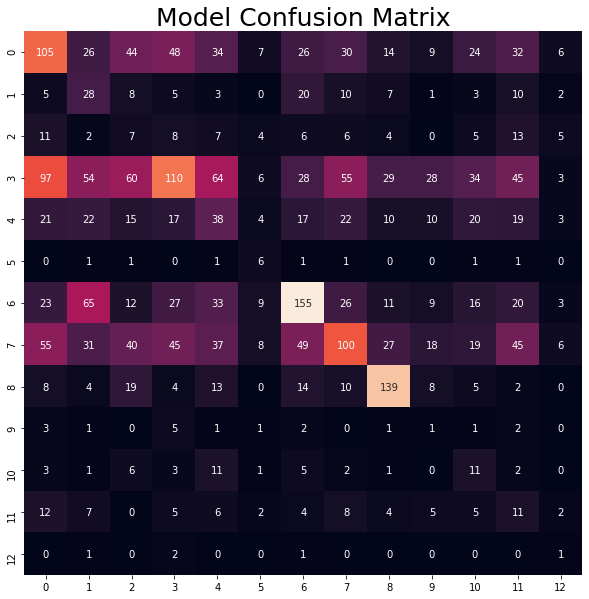

In [61]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [62]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.25925926 0.2745098  0.08974359 0.17944535 0.17431193 0.46153846
 0.37897311 0.20833333 0.61504425 0.05555556 0.23913043 0.15492958
 0.2       ]

Precision: [0.30612245 0.11522634 0.03301887 0.39426523 0.15322581 0.125
 0.47256098 0.37037037 0.56275304 0.01123596 0.07638889 0.05445545
 0.03225806]

Recall mean: 0.25313651122006536

Precision mean: 0.2082216484771022


In [63]:
#fittedgrid.best_estimator_.feature_importances_()

fittedgrid.best_estimator_[1].feature_importances_

array([0.06475172, 0.04624311, 0.05905456, 0.0418364 , 0.01526512,
       0.04992802, 0.01568742, 0.00834676, 0.0185412 , 0.01271755,
       0.        , 0.01476121, 0.01309038, 0.01163173, 0.01087092,
       0.00910399, 0.00579995, 0.02378513, 0.01281071, 0.0083823 ,
       0.01387609, 0.03470342, 0.01749158, 0.01204661, 0.02316125,
       0.00869278, 0.01414471, 0.00419391, 0.00861182, 0.01131148,
       0.00928329, 0.01447317, 0.0142157 , 0.00682652, 0.02320218,
       0.0035665 , 0.01368025, 0.01512761, 0.01458272, 0.00762954,
       0.01807835, 0.00397524, 0.01443542, 0.00879501, 0.01294388,
       0.01052828, 0.00694934, 0.00562506, 0.0105968 , 0.01673006,
       0.01276384, 0.01770053, 0.0125962 , 0.01575357, 0.00998746,
       0.00925741, 0.01249484, 0.01830538, 0.01313627, 0.00587194,
       0.01582805, 0.0171427 , 0.01707509])

In terms of accuracy, the DecisionTree performs better without PCA.

### KNN 

Int the case of KNN, it is important to combine the model with PCA

In [69]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names



estimators = [('dimensionality', PCA()),
              ('model', KNeighborsClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{ 'dimensionality':[PCA()],
 'model': [KNeighborsClassifier()],
  'dimensionality__n_components':np.arange(1,min(X_rf.shape)),
  'model__n_neighbors':np.arange(1, 7)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_rf, y_rf)

Fitting 5 folds for each of 714 candidates, totalling 3570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1492 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 2392 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3492 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3563 out of 3570 | elapsed:  3.4min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 3570 out of 3570 | elapsed:  3.4min finished


Wall time: 3min 26s


C:\Users\francisco\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [73]:
# What is the best pipeline?
print(fittedgrid.best_estimator_)

# Accuracy
print('Accuracy:', fittedgrid.score(X_test, y_test))

print('')

# Score
print('Score:', fittedgrid.score(X_rf, y_rf))

Pipeline(steps=[('dimensionality', PCA(n_components=100)),
                ('model', KNeighborsClassifier(n_neighbors=1))])
Accuracy: 0.3289865871833085

Score: 1.0


In [80]:
acc_dic['KNN_with_PCA'] = ('Acc: 0.32', 'Score: 1.0' )

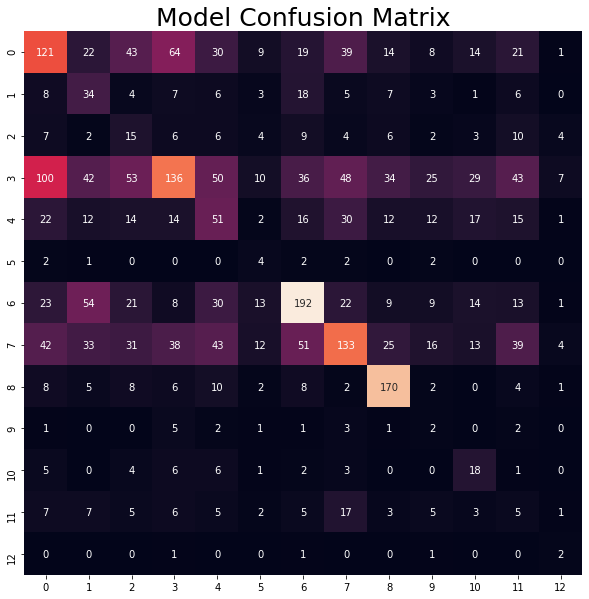

In [74]:
# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [75]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

Recall: [0.29876543 0.33333333 0.19230769 0.22185971 0.23394495 0.30769231
 0.46943765 0.27708333 0.75221239 0.11111111 0.39130435 0.07042254
 0.4       ]

Precision: [0.34971098 0.16037736 0.07575758 0.45791246 0.21338912 0.06349206
 0.53333333 0.43181818 0.60498221 0.02298851 0.16071429 0.03144654
 0.09090909]

Recall mean: 0.3122672919689814

Precision mean: 0.24591013111221158


Let us compare the different accuracies and scores we have obtained so far

In [82]:
acc_dic

{'RF_without_PCA': ('Acc: 0.37', 'Score: 1.0'),
 'RF_with_PCA': ('Acc: 0.34', 'Score: 1.0'),
 'DT_without_PCA': ('Acc: 0.30', 'Score: 0.9'),
 'DT_with_PCA': ('Acc: 0.26', 'Score: 0.96'),
 'KNN_with_PCA': ('Acc: 0.32', 'Score: 1.0')}

In terms of accuracy, Random Forest without PCA is the best. 

#### We are ready to start running our models.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS
SCORERS.keys()

### DecissionTre

In [ ]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[None],
 'model': [DecisionTreeClassifier()],
 'model__max_depth':np.arange(1, 20)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_over, y_over)

In [ ]:
# What is the best pipeline?
fittedgrid.best_estimator_

In [ ]:
# Score
fittedgrid.score(X_test, y_test)

In [ ]:
fittedgrid.score(X_remainder, y_remainder)

In [ ]:
%%time
from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [ ]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

These scores are acceptable 

In [ ]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('dimensionality', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{'dimensionality':[None],
 'model': [DecisionTreeClassifier()],
 'model__max_depth':np.arange(1, 80)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_resampled, y_resampled)

In [ ]:
# What is the best pipeline?
fittedgrid.best_estimator_

In [ ]:
# Score
fittedgrid.score(X_test, y_test)
#0.28

In [ ]:
# Score
fittedgrid.score(X_under, y_under)
#1.0

In [ ]:
y_pred = fittedgrid.predict(X_test)
y_pred

In [ ]:
%%time
from sklearn.metrics import confusion_matrix

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

### KNN

In [ ]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names



estimators = [('dimensionality', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{ 'dimensionality':[PCA()],
 'model': [KNeighborsClassifier()],
  'dimensionality__n_components':np.arange(1,min(X_resampled.shape)),
  'model__n_neighbors':np.arange(5, 10)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_under, y_under)

In [ ]:
# What is the best pipeline?
fittedgrid.best_estimator_

In [ ]:
# Score
fittedgrid.score(X_test, y_test)

In [ ]:
fittedgrid.score(X_under, y_under)

In [ ]:
%%time
from sklearn.metrics import confusion_matrix

# Let's get the prediction vector
y_pred = fittedgrid.predict(X_test)

y_pred = fittedgrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [ ]:
recall = np.diag(conf_mat)/np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat)/np.sum(conf_mat, axis = 0)

print('Recall:', recall)

print('')

print('Precision:', precision)

print('')

print('Recall mean:', np.mean(recall))

print('')

print('Precision mean:', np.mean(precision))

In [ ]:
# Let's recall the number of components in our data

print('X_remainder shape', X_remainder.shape)
print('maximum possible number of components to feed our PCA model:', min(X_remainder.shape))

### Below we can see different methods we use to balance the dataset

### Undersampling Cluster Centroids

In [ ]:
%%time
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=2020)
X_r_centroid, y_r_centroid= cc.fit_resample(X_remainder, y_remainder)
print(sorted(Counter(y_r_centroid).items()))

In [ ]:
plt.figure()
sns.distplot(y_r_centroid, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Dependent variable (train) after resampling')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [ ]:
%%time
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names



estimators = [('dimensionality', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
{ 'dimensionality':[PCA()],
 'model': [KNeighborsClassifier()],
  'dimensionality__n_components':np.arange(1,min(X_resampled.shape)),
  'model__n_neighbors':np.arange(3, 25)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_r_centroid, y_r_centroid)

In [ ]:
# What is the best pipeline?
fittedgrid.best_estimator_

In [ ]:
# Score
fittedgrid.score(X_test, y_test)

### Random undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=20)
X_random_u, y_random_u = rus.fit_resample(X_remainder, y_remainder)
print(sorted(Counter(y_random_u).items()))

In [ ]:
plt.figure()
sns.distplot(y_random_u, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Dependent variable (train) after resampling')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

### Resampling Tomek:
It gives interesting results

In [ ]:
%%time
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_remainder, y_remainder)
print(sorted(Counter(y_resampled).items()))

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_remainder, y_remainder)
print(sorted(Counter(y_resampled).items()))

In [ ]:
%%time
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_remainder, y_remainder)
print(sorted(Counter(y_resampled).items()))

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_remainder, y_remainder)
print(sorted(Counter(y_resampled).items()))

plt.figure()
sns.distplot(y_resampled, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Dependent variable (train) after resampling')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.figure()
sns.distplot(y_test, kde=False) # Enable `kde` if you also want a curve to be plotted; in this case I've disabled it
#plt.axvline(y.mean(), c='r', label='Mean') # Plot the mean
#plt.axvline(y.median(), c='gold', label='Median') # Plot the median
#plt.legend() # Make a legend so we know which line is the mean and which is the median
plt.title('Dependent variable (test)')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [ ]:
4+4